In [1]:
# Basic NGSolve things
from netgen.csg import *
from ngsolve import *
from ngsolve.webgui import Draw

import matplotlib.pyplot as plt
import numpy as np
import matplotlib 
matplotlib.rcParams.update({'font.size': 18})

# %matplotlib inline
import compare_my_method
plt.rc('text', usetex=False) # don't use Latex as Binder currently fails, see https://github.com/jupyterhub/binderhub/issues/1143

# conforming mesh

In [2]:
def GenMesh(h0=10, h1=8):
    # get geometry
    cube1 = OrthoBrick( Pnt(0,0,0), Pnt(100,100,10) )
    cube2 = OrthoBrick( Pnt(0,0,10), Pnt(100,100,20) )
    cube3 = OrthoBrick( Pnt(0,0,80), Pnt(100,100,90) )
    cube4 = OrthoBrick( Pnt(0,0,90), Pnt(100,100,100) )

    # change cube5 to include fracture
    cube5 = OrthoBrick( Pnt(0,0,20), Pnt(100,100,80) )
    plane1 = Plane(Pnt(50,50,50), Vec(-3,0,-5))
    plane2 = Plane(Pnt(50,50,50), Vec(3,0,5))

    split1 = cube5-plane1
    split2 = cube5-plane2

    cube1.mat("o3")
    cube2.mat("o2") 
    split1.mat("o2")
    cube3.mat("o2") 
    split2.mat("o2")
    cube4.mat("o2") 

    geo = CSGeometry()
    geo.Add(split2.maxh(h1))
    geo.Add(split1.maxh(h1))
    geo.Add(cube1)
    geo.Add(cube2)
    geo.Add(cube3)
    geo.Add(cube4)
    mesh = Mesh(geo.GenerateMesh(maxh=h0))

    # postprocess to get boundary flags
    lists={0: "bb", 1: "back", 2: "back", 3: "front", 4: "right", 5:"top", 6:"left1", 7:"back", 8:"front",
           9:"right", 10:"bb", 11:"left",12:"front", 13:"right", 14:"left", 15:"back", 16:"front", 17:"right",
           18:"bb", 19:"bottom", 20:"left", 21:"back1", 22:"front", 23:"left", 24:"bb", 25:"back", 
           26:"front", 27:"right", 28:"frac"
          }
    for i in range(len(lists)):
        mesh.ngmesh.SetBCName(i, lists[i])

#     print(mesh.ne, mesh.GetBoundaries())
#     print(mesh.GetMaterials())
#     gfu = GridFunction(H1(mesh))
#     gfu.Set(1, definedon=mesh.Boundaries("back1|left1"))
#     gfu.Set(1, definedon=mesh.Materials("o3"))
#     Draw(gfu)
    K_values = {'o2': 1e-6, 'o3': 1e-5}
    values_list = [K_values[dom]
                   if dom in K_values.keys() else 0
                   for dom in mesh.GetMaterials()]
    K0 = CoefficientFunction(values_list)
    epsK1 = 1e-3 
    
    V = Compress(SurfaceL2(mesh, order=0, definedon=mesh.Boundaries("frac")))
    print("matrix elements: ", mesh.ne, "; fracture elements: ", V.ndof)
    return mesh, K0, epsK1
mesh, K0, epsK1 = GenMesh(h0=10, h1=8)
mesh, K0, epsK1 = GenMesh(h0=4, h1=4)

matrix elements:  10232 ; fracture elements:  448
matrix elements:  111795 ; fracture elements:  1758


#  Hybrid-Mixed: used a hacker for facetsurface

matrix elements:  10232 ; fracture elements:  448


WebGuiWidget(value={'ngsolve_version': '6.2.2103-72-g646b7caba', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'd…

NE:  10232 NDOF-g:  23377 NDOF-M: 21334 NDOF-Vf:  1344 NDOF-Mf:  699 NDOF-l: 51160
matrix elements:  111795 ; fracture elements:  1758


WebGuiWidget(value={'ngsolve_version': '6.2.2103-72-g646b7caba', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'd…

NE:  111795 NDOF-g:  235619 NDOF-M: 227654 NDOF-Vf:  5274 NDOF-Mf:  2691 NDOF-l: 558975


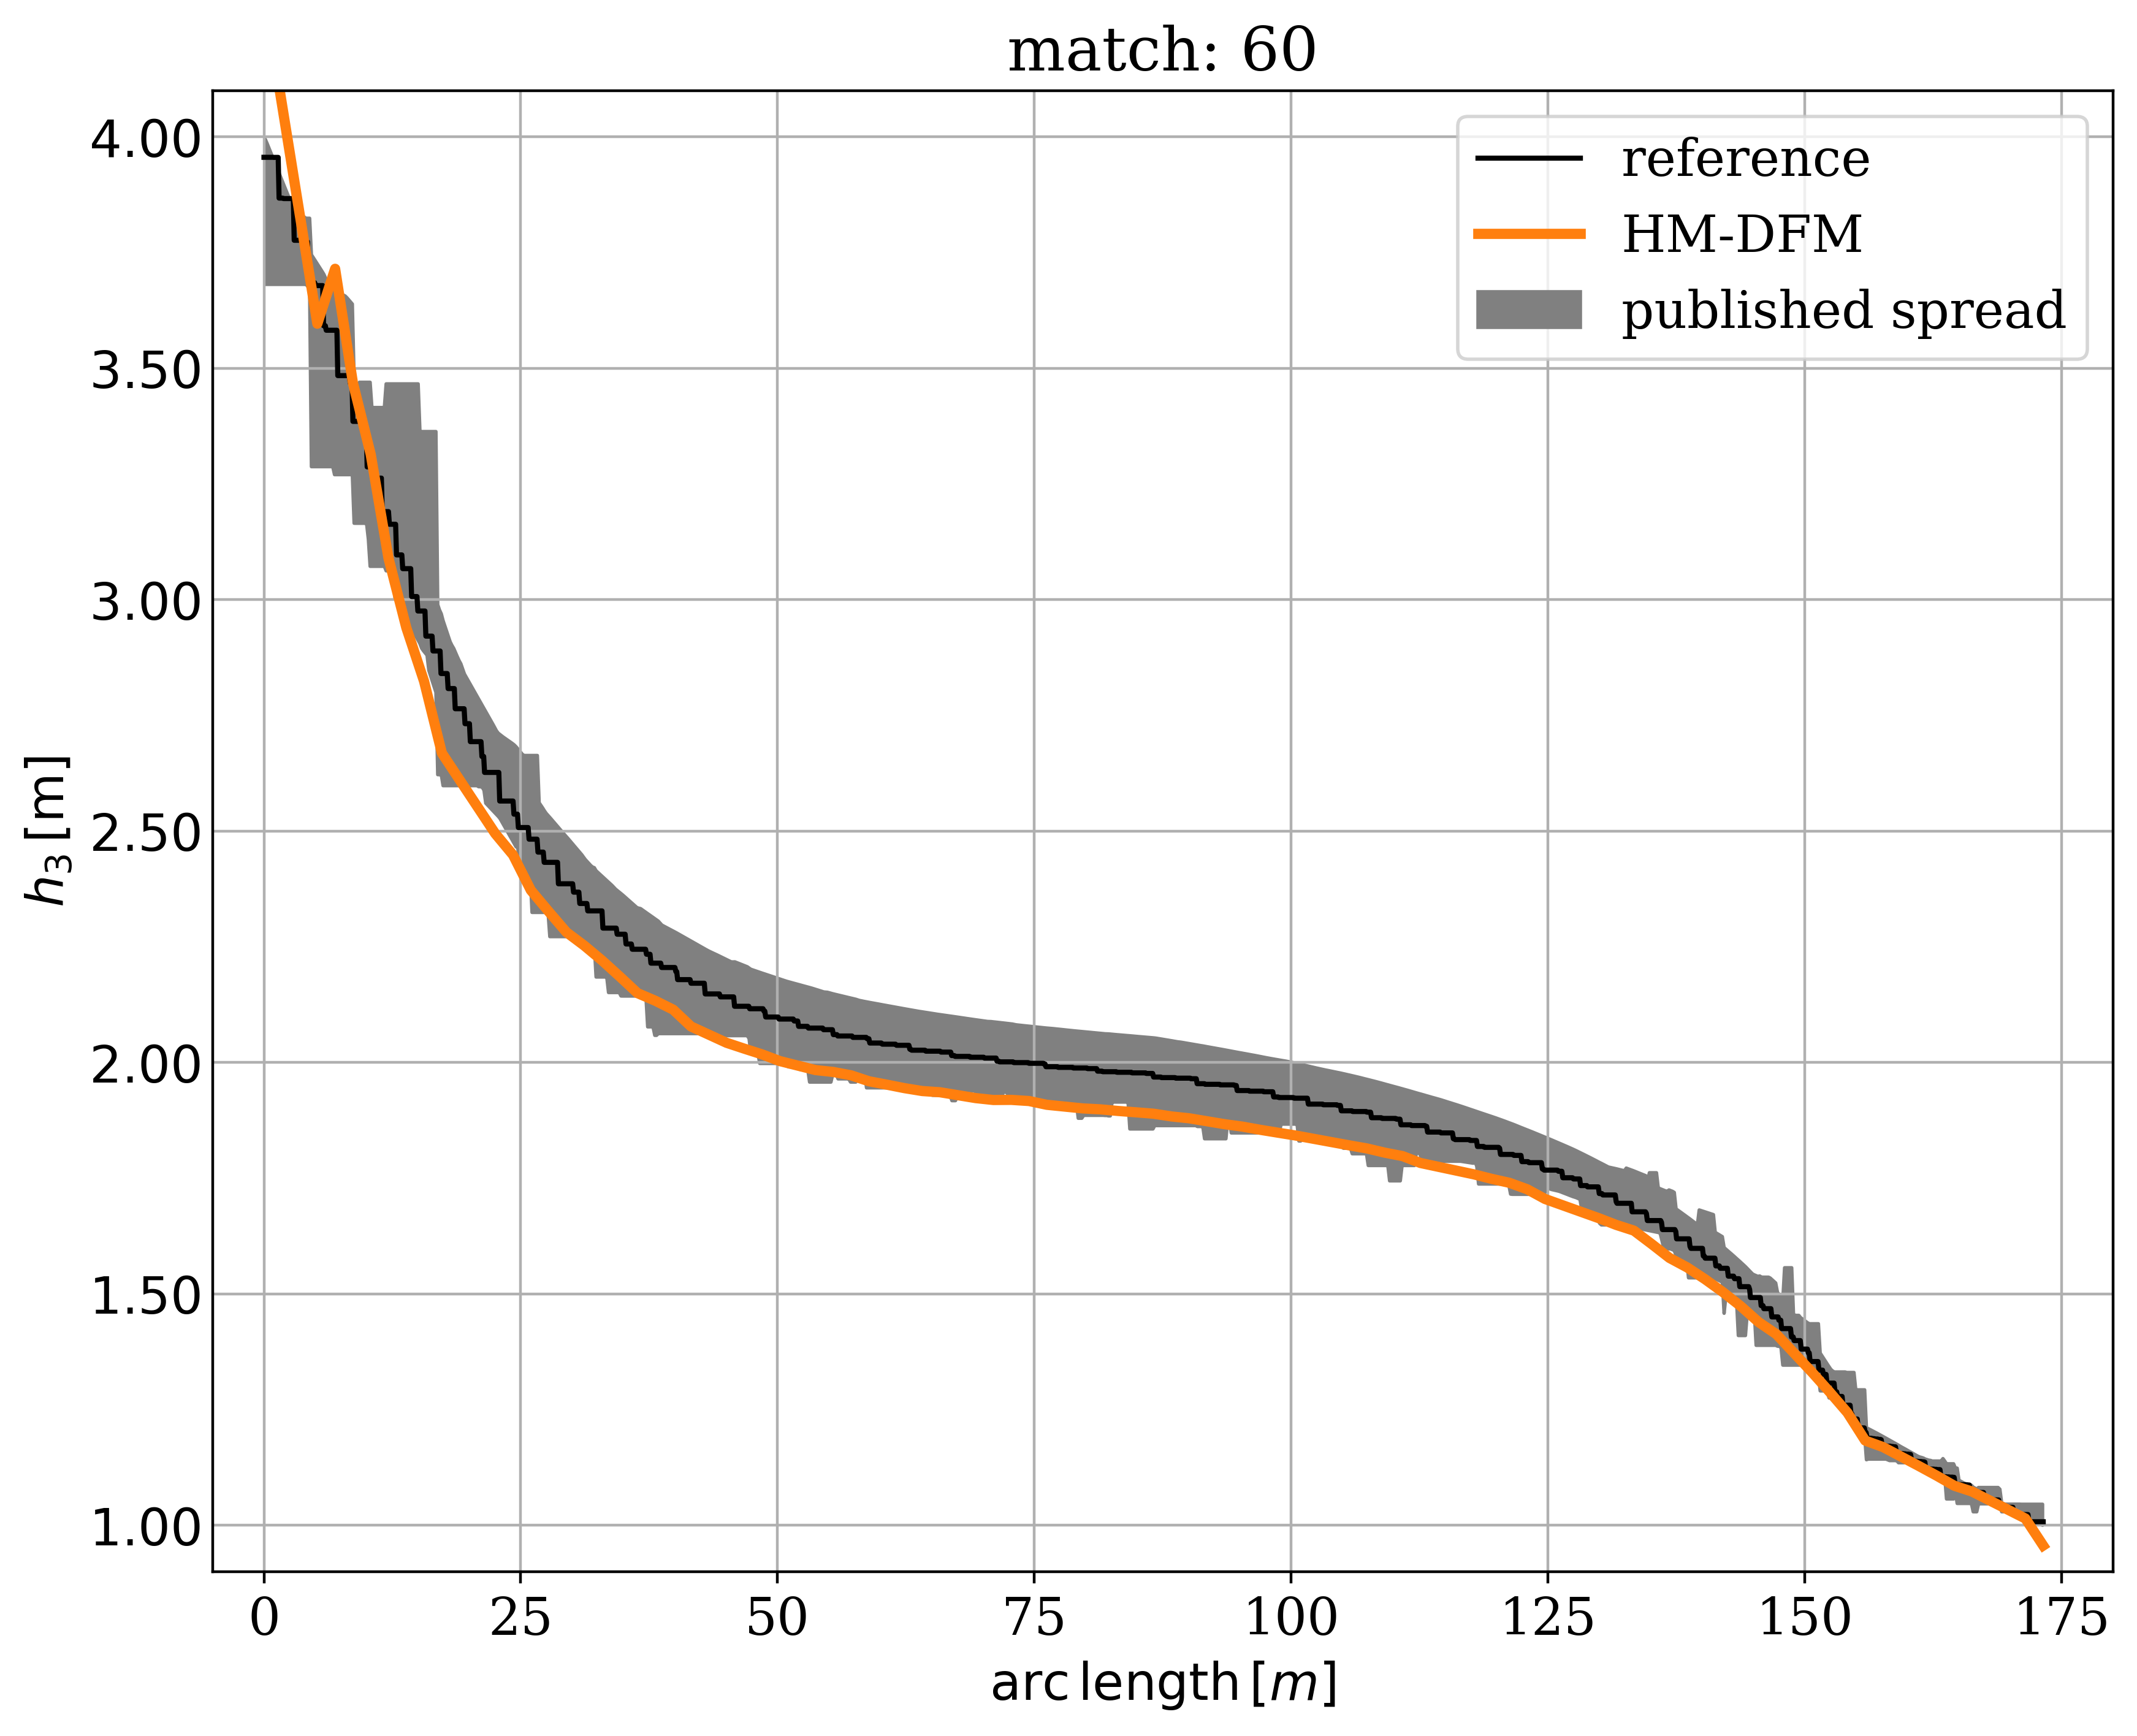

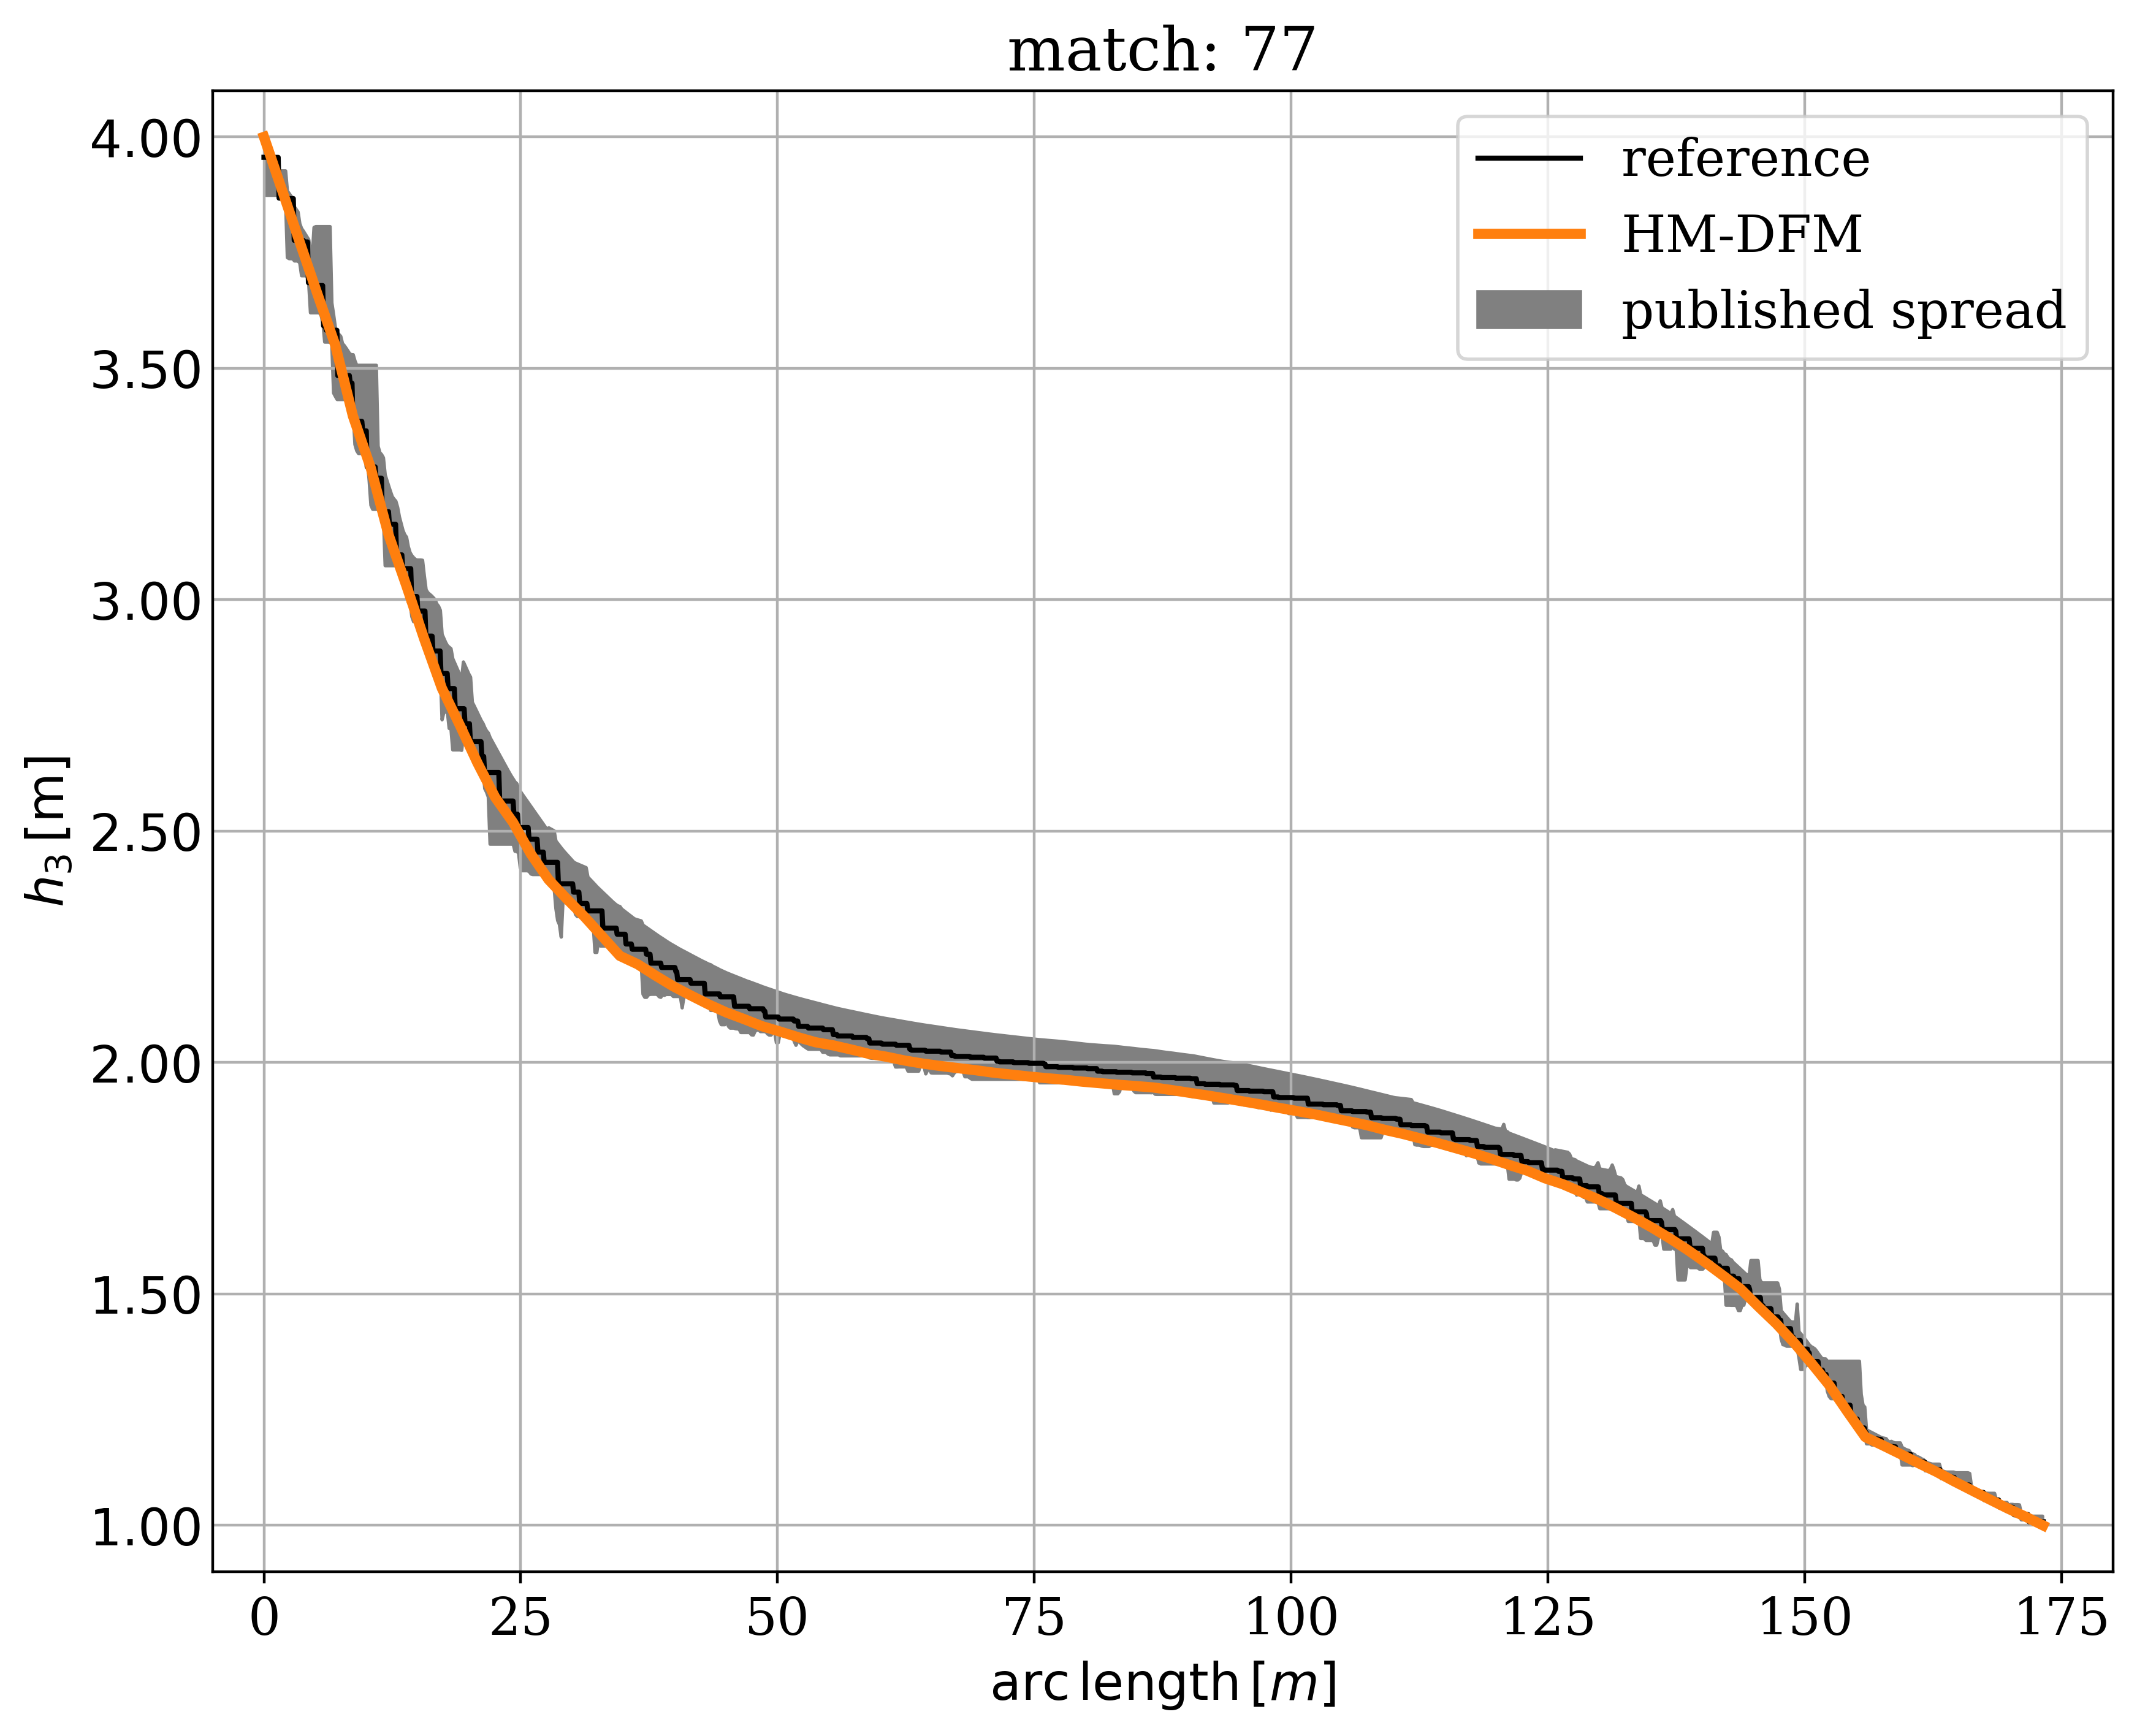

In [4]:
# hybrid-mixed solver: GOOD
for i in range(2):
    if i == 0:
        mesh, K0, epsK1 = GenMesh(h0=10, h1=8) # coarse mesh
    else:
        mesh, K0, epsK1 = GenMesh(h0=4, h1=4) # fine mesh
    order = 0
    frac = "frac"
    V = Discontinuous(HDiv(mesh, order=order, RT=True))
    W = L2(mesh, order=order)
    M = FacetFESpace(mesh, order=order, dirichlet="left1|back1")
    Vf = Discontinuous(HDivSurface(mesh, order=order, RT=True),BND=True)
    # set Vf dofs as interface dofs
    for el in Vf.Elements(BND):
        if el.mat =="frac":
            for dof in el.dofs:
                Vf.FreeDofs()[dof] = True
                Vf.SetCouplingType(dof, COUPLING_TYPE.INTERFACE_DOF)
        else:
            for dof in el.dofs:
                Vf.FreeDofs()[dof] = False
                Vf.SetCouplingType(dof, COUPLING_TYPE.UNUSED_DOF)
    Vf = Compress(Vf)
    # Mf = Compress(FacetSurface(mesh, order=order, definedon=mesh.Boundaries(frac)))
    Mf = Compress(HCurl(mesh, order=order, definedon=mesh.Boundaries(frac))) # hacker?!

    fes = V*W*M*Vf*Mf

    h = specialcf.mesh_size
    n = specialcf.normal(3)
    t = specialcf.tangential(3)
    t0 = specialcf.tangential(3, True)
    con = Cross(n,t) # in-plane normal

    (u, p, phat, uf, pbar0), (v, q, qhat, vf, qbar0) = fes.TnT()
    pbar = pbar0.Trace()*t0
    qbar = qbar0.Trace()*t0

    condense=True
    a = BilinearForm(fes, condense=condense)

    # subdomain 1
    a += (1/K0*u*v-p*div(v)-q*div(u))*dx
    a += (1/epsK1*uf.Trace()*vf.Trace()-phat.Trace()*div(vf).Trace()-qhat.Trace()*div(uf).Trace()
         )*ds("frac")
    a += (v*n*phat+u*n*qhat)*dx(element_boundary=True)
    a += (vf.Trace()*con*pbar+uf.Trace()*con*qbar)*ds(element_boundary=True, definedon=mesh.Boundaries("frac"))

    f = LinearForm(fes)

    gfu = GridFunction(fes)
    a.Assemble()
    f.Assemble()

    # dirichlet bc
    gfX0 = GridFunction(FacetFESpace(mesh, order=order))
    gfX1 = GridFunction(FacetFESpace(mesh, order=order))
    gfX0.Set(4, definedon=mesh.Boundaries("left1"))
    gfX1.Set(1, definedon=mesh.Boundaries("back1"))
    gfu.components[2].vec.data = gfX0.vec+gfX1.vec

    f.vec.data -= a.mat*gfu.vec
    if condense==True:
        f.vec.data += a.harmonic_extension_trans * f.vec
    gfu.vec.data += a.mat.Inverse(fes.FreeDofs(condense), inverse="umfpack")*f.vec
    if condense==True:
        gfu.vec.data += a.harmonic_extension * gfu.vec 
        gfu.vec.data += a.inner_solve * f.vec


    # Local postprocessing
    V2 = L2(mesh, order=order+1, all_dofs_together=False)
    ph = GridFunction(V2)

    a2 = BilinearForm(V2)
    f2 = LinearForm(V2)

    p2, q2 = V2.TnT()
    a2 += grad(p2)*grad(q2)*dx
    a2.Assemble()
    f2 += -1/K0*gfu.components[0]*grad(q2)*dx
    f2.Assemble()

    V2.FreeDofs()[:mesh.ne]=False
    ph.vec[:mesh.ne].data=gfu.components[1].vec[:mesh.ne]
    ph.vec.data += a2.mat.Inverse(V2.FreeDofs())*f2.vec

    gfInterp = GridFunction(H1(mesh, order=order+1))
    gfInterp.Set(gfu.components[1])
    Draw(gfInterp, mesh, "soln")

    ng = sum(fes.FreeDofs(True))
    nt = sum(fes.FreeDofs())
    print("NE: ", mesh.ne, "NDOF-g: ", ng, "NDOF-M:", sum(M.FreeDofs(True)), 
          "NDOF-Vf: ", sum(Vf.FreeDofs(True)), "NDOF-Mf: ", sum(Mf.FreeDofs(True)), "NDOF-l:", nt-ng)
    # data visualization over line
    xx = np.linspace(0, 100, 101)
    h = np.array([ph(mesh(x, 100-x, 100-x)) for x in xx])
    xx = xx*sqrt(3)

    plt.figure(figsize=(10,8), dpi=400)
    case = 1
    plot_id = "a"
    ref_index = 1+i
    subdomain_id = 0
    compare_my_method.evaluate(xx, h, case, plot_id, ref_index, subdomain_id, name="HM-DFM")
    plt.axis([-5,180, 0.9,4.1])


    plt.savefig("data/single"+str(i+1)+".pdf", dpi=400)